# Практика по базовой математической статистике для Data scientist

# Практика 1 - анализ распределения случайной величины

- Генерация распределений - делаем синтетический датасет по заданным параметрам распределений (пара вариантов из непрерывных функций)
- Построение гистограммы распределения при помощи mathplotlib / seaborn.
- Анализ основных метрик распределения с помощью pandas и numpy - учимся делать выводы по оценкам случайной величины и форме распределения.

Для начала импортируем все полезные библитеки и настроим ноутбук

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

Пусть у нас будут два датасета - прибыль по клиентам разных групп, распределенные по нормальному закону N(500,1000) и Гамма закону, параметры которого будет необходимо вычислить на основе средней прибыли = 500 и среднеквадратическому отклонению = 1000.

Сгенерируем синтетические выборки размера ns = 10000 клиентов каждая.

In [ ]:
ns = 10000
n_mean = 500
n_sigma = 1000

## Работаем с симметричным распределением

Используем имитацию нормального распределения отсюда
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html

In [ ]:
v = np.random.normal(n_mean, n_sigma, ns)
v = pd.DataFrame(v,columns = ["volume"])
v.volume = round(v.volume,0)

In [ ]:
v.head()

,volume
0,-1452.0
1,365.0
2,1097.0
3,1081.0
4,3537.0


Для оценки среднего, среднеквадратического отклонения и квантилей можно воспользоваться отдельными методами pandas и numpy

In [ ]:
# Среднее
v.volume.mean()

505.73

In [ ]:
# Медиана
v.volume.median()

491.0

In [ ]:
# Мода
v.volume.value_counts().nlargest(10)

646.0     11
232.0     11
28.0      11
93.0      10
1029.0    10
128.0     10
65.0      10
840.0     10
782.0      9
148.0      9
Name: volume, dtype: int64

In [ ]:
# Среднеквадратическое отклонение - далее ско
v.volume.std()

995.9401020988674

In [ ]:
#  Квантиль - медиана
np.percentile(v.volume, 50)

491.0

In [ ]:
# Кванталь - 0.75
np.percentile(v.volume, 75)

1182.25

Однако, удобнее воспользоваться встроенные методом pandas describe()

In [ ]:
v.volume.describe()

count    10000.000000
mean       505.730000
std        995.940102
min      -3577.000000
25%       -170.250000
50%        491.000000
75%       1182.250000
max       4709.000000
Name: volume, dtype: float64

Здесь мы видим как среднее значение, так максимум, минимум, ско и все полезные квантили.

Теперь построим гистограмму распределения - сделаем это двумя способами, при помощи seaborn и встроенного метода pandas hist()

Text(0.5,1,'Распределение прибыли по пользователям группы 1')

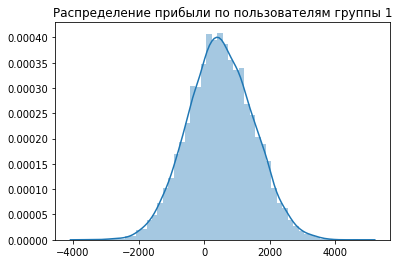

In [ ]:
# При помощи seaborn
sns.distplot(v)
plt.title("Распределение прибыли по пользователям группы 1")

Text(0.5,1,'Распределение прибыли по пользователям группы 1')

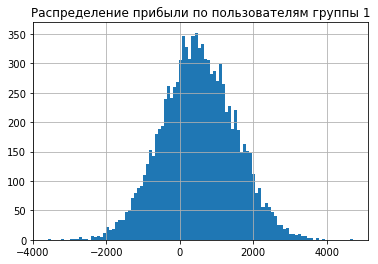

In [ ]:
# При помощи pandas
v.volume.hist(bins = 100)
plt.title("Распределение прибыли по пользователям группы 1")

И не забудем про коэффициенты эксцесса и ассиметрии

In [ ]:
# Эксцесс
kurtosis(v.volume)

-0.039510713998523794

In [ ]:
# Ассиметрия
skew(v.volume)

0.016844532044482

Теперь объединим все в одну функцию для удобства работы со вторй выборкой

In [ ]:
def my_basic_research(df=v, column = "volume"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sns.distplot(df[column])
    plt.title("Распределение прибыли по пользователям")

Базовые метрики
count    10000.000000
mean       505.730000
std        995.940102
min      -3577.000000
25%       -170.250000
50%        491.000000
75%       1182.250000
max       4709.000000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
646.0     11
232.0     11
28.0      11
93.0      10
1029.0    10
Name: volume, dtype: int64
------------------------------------
Эксцесс  -0.039510713998523794
Ассиметрия  0.016844532044482


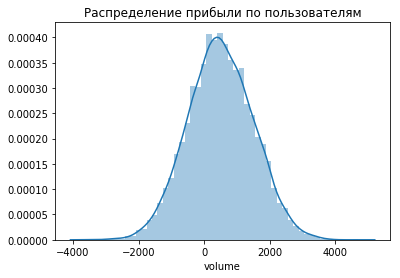

In [ ]:
# Опробуем нашу функцию.
my_basic_research()

## Проверим на ассиметричном распределении

Вот так выглядит случай симметричных данных. Но в мире не все распределения симметричны - поэтому попробуем выяснить, чем это нам грозит, повторив анализ для Гамма распределения. Для начала подготовим датасет.

Параметры Гамма закона k и theta связаны со средним и дисперсией этого закона следующим образом (https://ru.wikipedia.org/wiki/Гамма-распределение):

$$m(x)=k*theta$$
$$D(x)=k*theta^2$$

Решая как систему уравнений, получим:

$$ k=(m(x)^2)/D(x)$$
$$theta=D(x)/m(x)$$

Зададим функцию для поиска параметров Гамма распределения по среднему и СКО

In [ ]:
def gamma_params(mean, std):
    shape = round((mean/std)**2, 4)
    scale = round((std**2)/mean, 4)
    return (shape, scale)

In [ ]:
shape, scale = gamma_params(n_mean, n_sigma)
df = np.random.gamma(shape, scale, ns)
df = pd.DataFrame(df,columns = ["volume"])

# Округлим до целых
df.volume = round(df.volume,0)

In [ ]:
df.head()

,volume
0,707.0
1,0.0
2,1223.0
3,0.0
4,15.0


Базовые метрики
count    10000.000000
mean       518.284700
std       1048.956372
min          0.000000
25%          6.000000
50%         97.000000
75%        540.000000
max      18014.000000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
0.0    1336
1.0     453
2.0     245
3.0     177
6.0     127
Name: volume, dtype: int64
------------------------------------
Эксцесс  27.40347440191345
Ассиметрия  4.214029319719516


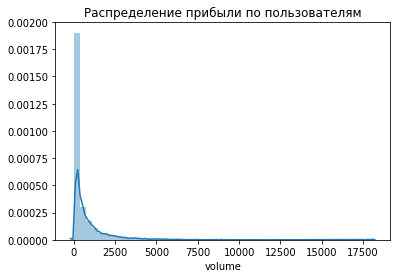

In [ ]:
my_basic_research(df = df, column = "volume")

Как можно увидеть, теперь мы имеем дело а ассиметричным распределением и все квантили, а такде коэффициенты ассиметрии и эксцесса поменялись, несмотря на равенство средних и ско - и выводы по этим датасетам получаются абсолютно разные.

К примеру, сравним долю убыточных клиентов для первого и второго датасетов:

In [ ]:
v[v.volume < 0].count()/len(v)

volume    0.3052
dtype: float64

In [ ]:
df[df.volume < 0].count()/len(df)

volume    0.0
dtype: float64

А теперь сравним суммарную прибыль по клиентам с прибылью свыше медианы в млн:

In [ ]:
v[v.volume >= np.percentile(v.volume,50)].volume.sum()/10**6

6.509022

In [ ]:
df[df.volume >= np.percentile(df.volume,50)].volume.sum()/10**6

5.089377

Как можно видеть, эффект от ассимерии при одинаковых средних и ско существенно менять выводы.

## Мини домашка

Найдите медиану для Гамма распределения со средним = 1000 и среднеквадратичным отклонением = 3000, не округляя значения синтетического датасета.
Какое число получилось?